# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder
# some technical imports 
import operator
import time
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';') 

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# print all columns values of azdias
print(list(azdias.columns.values))

# calculate the file information from demographic data
num_rows, num_cols  = azdias.shape
print('azdias Number of columns: {}'.format(num_cols))
print('azdias Number of rows: {}'.format(num_rows))

# show a preview about azdias data
azdias.describe()
azdias.head()

['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# print all columns values of feature data
# feat_info.set_index('attribute', inplace=True)
print(list(feat_info.columns.values))

# calculate the file information from feature data
num_rows, num_cols  = feat_info.shape
print('feat info Number of columns: {}'.format(num_cols))
print('feat info Number of rows: {}'.format(num_rows))

# show a preview about feat info data
feat_info.describe()
feat_info.head()

['attribute', 'information_level', 'type', 'missing_or_unknown']
feat info Number of columns: 4
feat info Number of rows: 85


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
def is_int(value):
  try:
    int(value)
    return True
  except ValueError:
    return False

# Make a dictionary with attribute and NaN values
data_dict = {'nan_vals': feat_info['missing_or_unknown'] \
             .str.replace('[','').str.replace(']','').str.split(',').values}
missing_vals = pd.DataFrame(data_dict, index = feat_info['attribute'].values)
missing_vals['nan_vals'] = missing_vals.apply(lambda x: [int(i) if is_int(i) == True else i for i in x[0]], axis=1)

# Parse from string to list of values
for column in azdias.columns:
    azdias[column] = azdias[column].replace(missing_vals.loc[column][0], np.nan)

# show the conversion ...                
print('Total number of missing values after conversion is {}'.format(azdias.isnull().sum().sum()))                

Total number of missing values after conversion is 8373929


In [6]:
# save the converted data in a new file ... low performance but better to check the results
# azdias.to_csv('azdias_conv.csv', sep=';', index = False)

In [7]:
# reload the converted file 
# azdias = pd.read_csv('azdias_conv.csv', delimiter=';')

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missdata = azdias.isnull().sum()
missdata = missdata[missdata > 0]/(azdias.shape[0]) * 100
missdata.sort_values(inplace=True)

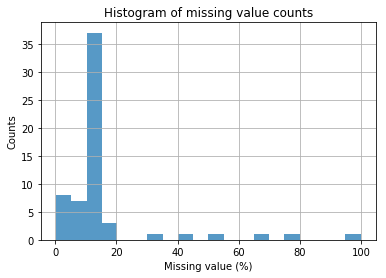

In [9]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missdata, bins=20, alpha=0.75)
plt.ylabel('Counts')
plt.xlabel('Missing value (%)')
plt.title('Histogram of missing value counts')
plt.grid(True)
plt.show()

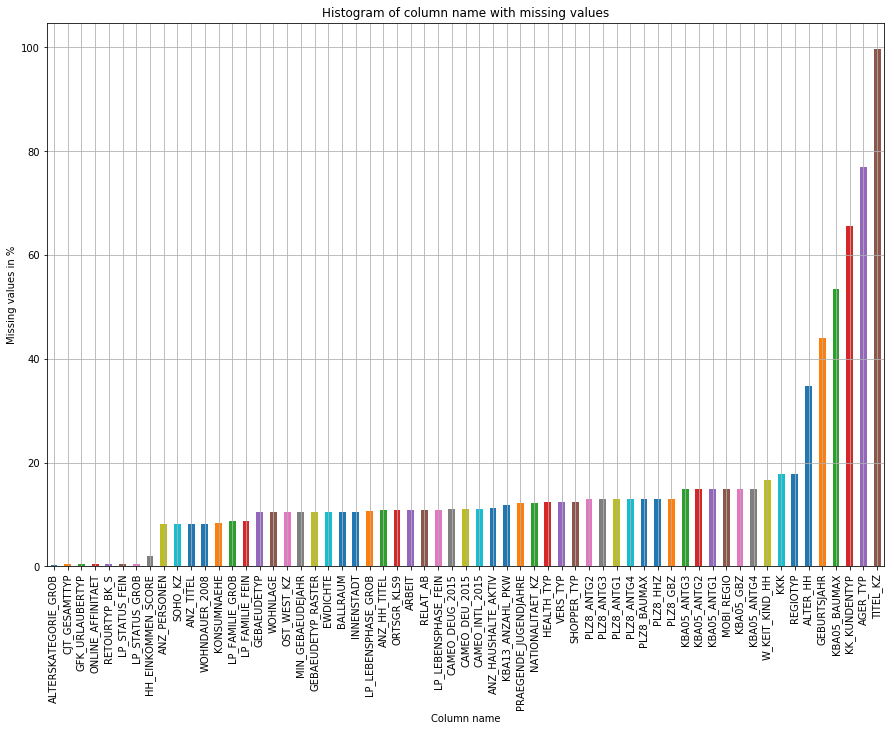

There are 61 columns with missing values.


In [10]:
# show the data with their distribution
missdata.plot.bar(figsize=(15,10))
plt.xlabel('Column name')
plt.ylabel('Missing values in %')
plt.title('Histogram of column name with missing values')
plt.grid(True)
plt.show()
print("There are {} columns with missing values.".format(len(missdata)))

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# The histogram showed ca. 15 % columns with missing data
missdata_perc = missdata[missdata>15]
# check these column .. 
drop_col = missdata_perc.index.tolist()
print('Columns with more than 15 % missing data and dropped:{}'.format(drop_col))

Columns with more than 15 % missing data and dropped:['W_KEIT_KIND_HH', 'KKK', 'REGIOTYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']


In [12]:
# Show before drop ...
print('Before dropping null values:')
# calculate the file information from demographic data
num_rows, num_cols  = azdias.shape
print('azdias Number of columns: {}'.format(num_cols))
print('azdias Number of rows: {}'.format(num_rows))
# now drop these columns ...
azdias = azdias.drop(drop_col, axis=1)
# ... and show the result 
print('After dropping null values:')
# calculate the file information from demographic data
num_rows, num_cols  = azdias.shape
print('azdias Number of columns: {}'.format(num_cols))
print('azdias Number of rows: {}'.format(num_rows))
print(list(azdias.columns.values))
azdias.head()

Before dropping null values:
azdias Number of columns: 85
azdias Number of rows: 891221
After dropping null values:
azdias Number of columns: 76
azdias Number of rows: 891221
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR',

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
# also remove dropped columns from feature info data

# don't do this because for later steps I need the information 

# feat_info = feat_info[~feat_info['attribute'].isin(drop_col)]
# show a preview about feat info data again
# feat_info.describe()
# feat_info.head()

#### Discussion 1.1.2: Assess Missing Data in Each Column

The first histogram 'histogram of missing value count' shows me that about 15% of the columns contain missing or inadequate values. In the second histogram, the pattern is confirmed my observation by the columns. The most noticeable columns were removed from the file AZDIAS and the attributes from the feat info. In detail, it was the columns 'W_KEIT_KIND_HH', 'KKK', 'REGIOTYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

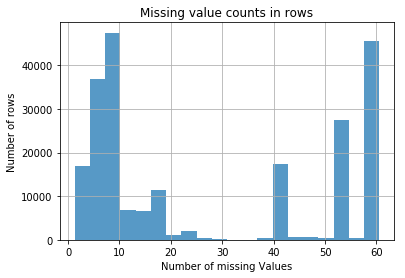

In [14]:
# How much data is missing in each row of the dataset?

# calculate 
missrow = azdias.isnull().sum(axis=1)
missrow = missrow[missrow > 0]/(len(azdias.columns)) * 100
missrow.sort_values(inplace=True)

# show ...
plt.hist(missrow, bins=20, alpha=0.75)
plt.ylabel('Number of rows')
plt.xlabel('Number of missing Values')
plt.title('Missing value counts in rows')
plt.grid(True)
plt.show()

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# Values in each rows with less and more than 3 missing values
azdias_few = azdias[azdias.isnull().sum(axis=1) < 3].reset_index(drop=True)
azdias_high = azdias[azdias.isnull().sum(axis=1) >= 3].reset_index(drop=True)

# check the data
print(azdias_few.shape)
azdias_few.head(3)

(678203, 76)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [16]:
# Compare the distribution of values for at least five columns where there are
# recalculate the percentage 
misscol =(azdias.isnull().sum()/len(azdias))*100
# no or few missing values, between the two subsets.
misscol_lt = misscol[misscol==0].index.tolist()
# Compare columns with few null values: Subset for 6 columns to discuss ....
compare_col = misscol_lt[:6]

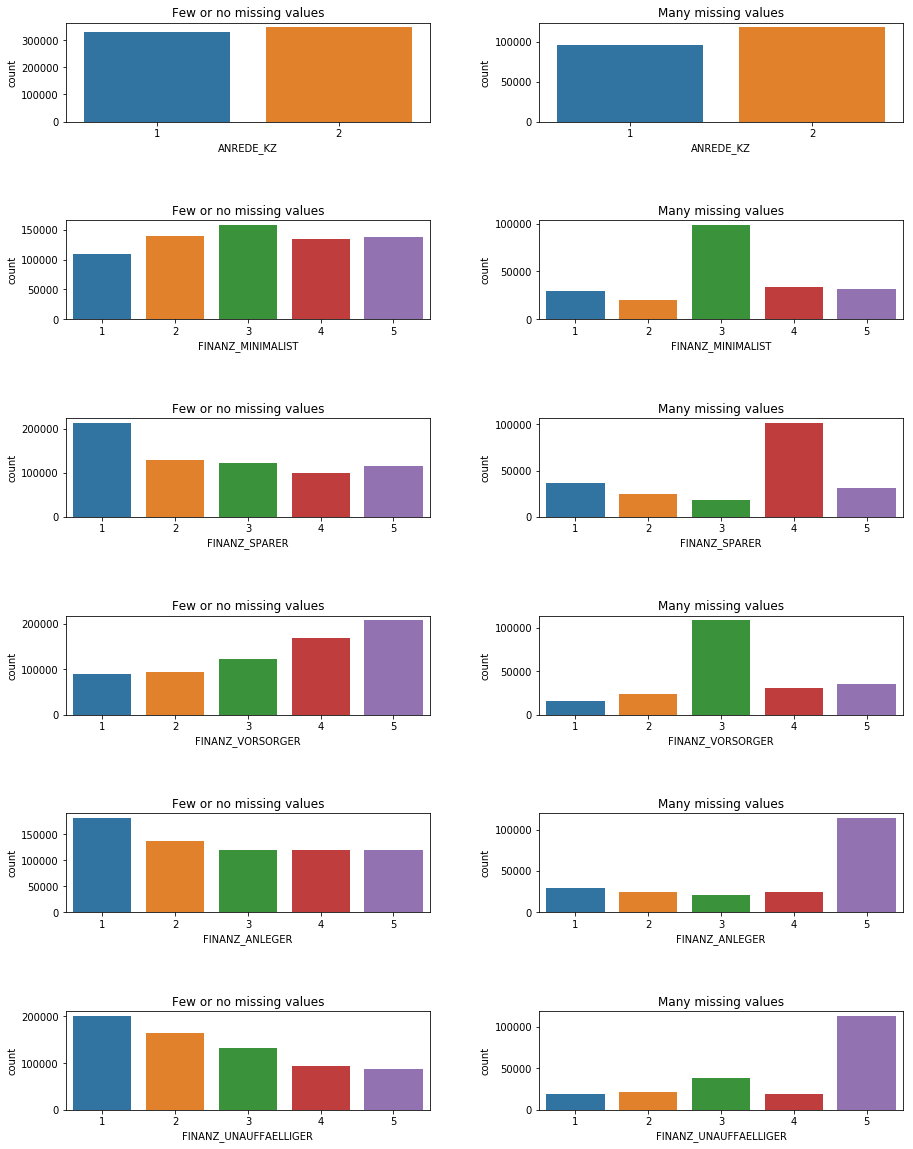

In [17]:
# plot the compare for 6 columns 
figure, axs = plt.subplots(nrows=len(compare_col), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)
for i in range(len(compare_col)):
    sns.countplot(azdias_few[compare_col[i]], ax=axs[i][0])
    axs[i][0].set_title('Few or no missing values')
    sns.countplot(azdias_high[compare_col[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

Are the data with lots of missing values are qualitatively different from data with few or no missing values?

From the graphs above it can be seen that the value distributions between the two records are similar for the salutation function, but for some functions, e.g. Analysis of financial status differ significantly.
For further progress, the outlier columns could be removed. This would give me a better runtime, but also seemingly a lower accuracy in the further evaluation.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# filling missing values with the mode 
for col in azdias_few.columns:
    azdias_few[col] = azdias_few[col].fillna(azdias_few[col].mode()[0])

In [19]:
# How many features are there of each data type?
feat_info.groupby(['type'])['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

features = list(azdias_few.columns)
features_clean = feat_info[feat_info['attribute'].isin(features)]
cat_features = features_clean[features_clean["type"]=="categorical"]["attribute"]

In [21]:
# split in binary and multi-level categoricals
bin_feature = []
multi_feature = []
for feature in cat_features:
    if (len(azdias_few[feature].unique())>2):
        multi_feature.append(feature)
    else:
        bin_feature.append(feature)

In [22]:
# show the results of both
print('Columns of binary features: {}'.format(bin_feature))
print('Columns of multi-level: {}'.format(multi_feature))

Columns of binary features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Columns of multi-level: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [23]:
# further show the unique information ..
for feature in bin_feature:
    print('Unique values for {} are {}'.format(feature, azdias_few[feature].unique()))

Unique values for ANREDE_KZ are [2 1]
Unique values for GREEN_AVANTGARDE are [0 1]
Unique values for SOHO_KZ are [ 1.  0.]
Unique values for VERS_TYP are [ 2.  1.]
Unique values for OST_WEST_KZ are ['W' 'O']


In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Clean the column OST_WEST_KZ .... 
azdias['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)

In [25]:
# the multi-level features are not longer neccassery .. drop these
for feature in multi_feature:
    azdias = azdias.drop(feature, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

In this data analysis, I had to make sure that only the columns needed for further evaluation were included. The following steps led to the result.

1. At first I split the data between binary and multi features.
2. Re-encoded the values in 'OST_WEST_KZ', 'ANREDE_KZ' and 'VERS_TYP' as numbers to keep it in analysis. 
3. Kept all binary features:'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'. 
4. Finaly I dropped all multi-level features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# show me about this columns
azdias[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
0,NaN
1,14.0
2,15.0
3,8.0
4,8.0


In [27]:
# create new varaibles for 'PRAEGENDE_JUGENDJAHRE' 
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'DECADE']=1
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'DECADE']=2
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]),'MOVEMENT']=1
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]),'MOVEMENT']=2
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]),'MOVEMENT']=3

In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# show me about this columns
azdias[['CAMEO_INTL_2015']].head()

,CAMEO_INTL_2015
0,NaN
1,51
2,24
3,12
4,43


In [29]:
# create new varaibles for 'CAMEO_INTL_2015'
azdias['CAMEO_INTL_2015'].value_counts()
azdias['CAMEO_INTL_2015']=azdias['CAMEO_INTL_2015'].astype(float)
azdias.loc[azdias['CAMEO_INTL_2015'].isin([51,52,53,54,55]),'WEALTH']=1
azdias.loc[azdias['CAMEO_INTL_2015'].isin([41,42,43,44,45]),'WEALTH']=2
azdias.loc[azdias['CAMEO_INTL_2015'].isin([31,32,33,34,35]),'WEALTH']=3
azdias.loc[azdias['CAMEO_INTL_2015'].isin([21,22,23,24,25]),'WEALTH']=4
azdias.loc[azdias['CAMEO_INTL_2015'].isin([11,12,13,14,15]),'WEALTH']=5
azdias.loc[azdias['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'LIFE_STAGE']=1
azdias.loc[azdias['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'LIFE_STAGE']=2
azdias.loc[azdias['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'LIFE_STAGE']=3
azdias.loc[azdias['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'LIFE_STAGE']=4
azdias.loc[azdias['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'LIFE_STAGE']=5

In [30]:
# Finaly drop features we don't use anymore 
azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

For the two features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 two new features were created by copying.
Then the characteristics were examined and adapted with new dictionary entries. Especially with CAMEO_INTL_2015 there were variants that could not be converted. For this a zero was defined.
The previous features have these both features droped.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [31]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Check that columns have the right type
np.unique(azdias.dtypes.values)

array([dtype('int64'), dtype('float64')], dtype=object)

In [32]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# show the results ... 
num_rows, num_cols  = azdias.shape
print('azdias Number of columns: {}'.format(num_cols))
print('azdias Number of rows: {}'.format(num_rows))
print(list(azdias.columns.values))

azdias.head()

azdias Number of columns: 65
azdias Number of rows: 891221
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTS

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,0,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,3.0,1.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,2.0,3.0,4.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,1.0,3.0,5.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,1.0,3.0,2.0,3.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [142]:
def clean_data(df, missing_vals, feat_info):
# def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # convert missing value codes into NaNs and
    # parse from string to list of values
    for col in range(df.shape[1]):
        col_name=df.columns[col]
        na_list=feat_info.iloc[col,3]
        na_list=na_list.replace('[', '')
        na_list=na_list.replace(']', '')
        na_list=na_list.split(',')
        if na_list == ['']:
            continue
        else:
            for na_code in na_list:
                if df[col_name].dtype =='object':
                    df.loc[df[col_name]==na_code,col_name]=np.nan
                else:  
                    na_code=int(na_code)
                    df.loc[df[col_name]==na_code,col_name]=np.nan
   
    # Re-encode categorical variable(s) to be kept in the analysis.
    # Clean the column OST_WEST_KZ etc. .... 
    df['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    df['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    df['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df['PRAEGENDE_JUGENDJAHRE'].value_counts()
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'DECADE']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'DECADE']=2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]),'MOVEMENT']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]),'MOVEMENT']=2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]),'MOVEMENT']=3
    df=df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df['CAMEO_INTL_2015'].value_counts()
    df['CAMEO_INTL_2015']=df['CAMEO_INTL_2015'].astype(float)
    df.loc[df['CAMEO_INTL_2015'].isin([51,52,53,54,55]),'WEALTH']=1
    df.loc[df['CAMEO_INTL_2015'].isin([41,42,43,44,45]),'WEALTH']=2
    df.loc[df['CAMEO_INTL_2015'].isin([31,32,33,34,35]),'WEALTH']=3
    df.loc[df['CAMEO_INTL_2015'].isin([21,22,23,24,25]),'WEALTH']=4
    df.loc[df['CAMEO_INTL_2015'].isin([11,12,13,14,15]),'WEALTH']=5
    df.loc[df['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'LIFE_STAGE']=1
    df.loc[df['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'LIFE_STAGE']=2
    df.loc[df['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'LIFE_STAGE']=3
    df.loc[df['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'LIFE_STAGE']=4
    df.loc[df['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'LIFE_STAGE']=5
    df=df.drop('CAMEO_INTL_2015', axis=1)

    missdata = df.isnull().sum()
    missdata = missdata[missdata > 0]/(df.shape[0]) * 100
    missdata.sort_values(inplace=True)
    # Remove the outlier columns from the dataset.
    # ca. 15 % columns with missing data
    missdata_perc = missdata[missdata>30]
    # now drop these columns ...
    drop_col = missdata_perc.index.tolist()
    df = df.drop(drop_col, axis=1)
     
    # split in binary and multi-level categoricals
    df_few = df[df.isnull().sum(axis=1) < 3].reset_index(drop=True)
    df_high = df[df.isnull().sum(axis=1) >= 3].reset_index(drop=True)
    
    # impute the remaining missing values
    for col in df_few.columns:
        df_few[col] = df_few[col].fillna(df_few[col].mode()[0])

    features = list(df_few.columns)
    features_clean = feat_info[feat_info['attribute'].isin(features)]
    cat_features = features_clean[features_clean["type"]=="categorical"]["attribute"]
    bin_feature = []
    multi_feature = []
    for feature in cat_features:
        if (len(df_few[feature].unique())>2):
            multi_feature.append(feature)
        else:
            bin_feature.append(feature)
            
    # the multi-level features are not longer neccassery .. drop these
    for feature in multi_feature:
        df.drop(feature,axis=1)
    
    # Return the cleaned dataframe.
    return df, drop_col 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [34]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# save data in features 
features = azdias.copy()
# Impute nans for features 
imputer = Imputer(strategy='median')
imputed_features = pd.DataFrame(imputer.fit_transform(features))
# append columns and indexes
imputed_features.columns = features.columns
imputed_features.index = features.index

In [35]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
azdias_standard = scaler.fit_transform(imputed_features)
azdias_standard = pd.DataFrame(azdias_standard, columns=list(imputed_features))

In [36]:
# show the results 
azdias_standard.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,-0.234601,...,-0.587083,0.366863,-0.317206,-0.157224,-0.120115,-0.049267,-0.494701,0.474352,-0.468366,0.080573
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,1.175204,...,-0.587083,1.456896,0.640354,-0.157224,-0.120115,0.729399,-0.494701,0.474352,-1.182728,-1.347861
2,0.239980,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,1.175204,...,-0.587083,0.366863,0.640354,-0.157224,-0.120115,-0.827934,2.021423,0.474352,0.960358,0.794789
3,1.231640,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.234601,...,-0.587083,-0.723171,0.640354,-1.216157,-1.039247,-0.049267,-0.494701,0.474352,1.674720,-0.633644
4,0.239980,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,1.175204,...,0.128428,-0.723171,-0.317206,0.901709,0.339451,1.508065,-0.494701,0.474352,-0.468366,0.080573


### Discussion 2.1: Apply Feature Scaling

The default scale was used to normalize the values. In this approach, NaN was set using the median per column. The median was chosen instead of the median, as it is more robust against outliers.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [37]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_standard)

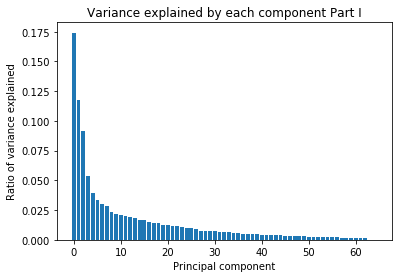

In [38]:
# Investigate the variance accounted for by each principal component.
# plot variance by each component ...
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component Part I")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

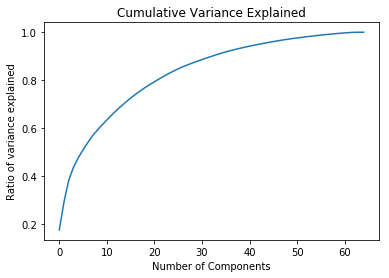

In [39]:
# plot cumulative variance 
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [40]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=35)
azdias_pca = pca.fit_transform(azdias_standard)

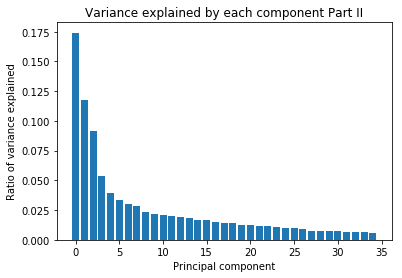

In [41]:
# Repeat plot variance by each component ...
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component Part II")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

First, PCA was applied to a set of components, as it represented more than half of the original features. When examining the variances in the histogram, it became clear that the top 35 components had to be selected. This confirmed the PCA repetition, which accounted for a cumulative variance of nearly 60% of the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [42]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# define function pca_weights including the sort
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_standard.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights
# show the first weights ...
pca_weight = pca_weights(pca, 0)
print (pca_weight)
# in order to be able to interpret the results, they must be stored between
step1_top = pca_weight.keys()[1:4].tolist()
step1_low = pca_weight.keys()[-4:-1].tolist()

PLZ8_ANTG3               0.231258
PLZ8_ANTG4               0.225298
PLZ8_BAUMAX              0.211736
ORTSGR_KLS9              0.203710
EWDICHTE                 0.202851
HH_EINKOMMEN_SCORE       0.170934
FINANZ_HAUSBAUER         0.166042
PLZ8_ANTG2               0.158291
KBA05_ANTG4              0.153142
ARBEIT                   0.144320
RELAT_AB                 0.137750
ANZ_HAUSHALTE_AKTIV      0.136155
KBA05_ANTG3              0.130365
FINANZ_SPARER            0.108370
SEMIO_PFLICHT            0.080459
SEMIO_REL                0.075457
SEMIO_RAT                0.066297
SEMIO_MAT                0.057224
SEMIO_FAM                0.055599
SEMIO_TRADV              0.052626
SEMIO_KAEM               0.052007
FINANZ_UNAUFFAELLIGER    0.045448
PLZ8_HHZ                 0.045236
VERS_TYP                 0.038822
FINANZ_ANLEGER           0.038781
SEMIO_KULT               0.037211
ANZ_HH_TITEL             0.036880
SEMIO_DOM                0.034476
SEMIO_KRIT               0.023631
SEMIO_SOZ     

In [43]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# show the second weights ...
pca_weight = pca_weights(pca, 1)
print (pca_weight)
# in order to be able to interpret the results, they must be stored between
step2_top = pca_weight.keys()[1:4].tolist()
step2_low = pca_weight.keys()[-4:-1].tolist()

ALTERSKATEGORIE_GROB     0.291192
FINANZ_VORSORGER         0.259133
SEMIO_ERL                0.256952
SEMIO_LUST               0.196004
RETOURTYP_BK_S           0.171096
FINANZ_MINIMALIST        0.107498
FINANZ_HAUSBAUER         0.088819
SEMIO_KAEM               0.085489
SEMIO_KRIT               0.082514
ANREDE_KZ                0.082350
ORTSGR_KLS9              0.069437
EWDICHTE                 0.067378
PLZ8_BAUMAX              0.065699
WOHNDAUER_2008           0.061865
KBA05_ANTG4              0.057263
SEMIO_DOM                0.052488
PLZ8_ANTG3               0.051891
ARBEIT                   0.051322
PLZ8_ANTG4               0.049844
ANZ_HAUSHALTE_AKTIV      0.048235
RELAT_AB                 0.048230
HH_EINKOMMEN_SCORE       0.042415
PLZ8_ANTG2               0.036488
KBA05_ANTG3              0.034317
ANZ_HH_TITEL             0.029941
LIFE_STAGE               0.020772
DECADE                   0.020456
GREEN_AVANTGARDE         0.020456
MOVEMENT                 0.019283
VERS_TYP      

In [44]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# show the third weights ...
pca_weight = pca_weights(pca, 2)
print (pca_weight)
# in order to be able to interpret the results, they must be stored between
step3_top = pca_weight.keys()[1:4].tolist()
step3_low = pca_weight.keys()[-4:-1].tolist()

SEMIO_VERT               0.355975
SEMIO_SOZ                0.286597
SEMIO_KULT               0.262485
SEMIO_FAM                0.210263
FINANZ_MINIMALIST        0.144432
RETOURTYP_BK_S           0.092901
FINANZ_VORSORGER         0.082411
DECADE                   0.073441
GREEN_AVANTGARDE         0.073441
PLZ8_BAUMAX              0.072168
ALTERSKATEGORIE_GROB     0.067136
ORTSGR_KLS9              0.054275
SEMIO_MAT                0.047632
EWDICHTE                 0.045261
KBA05_ANTG4              0.043644
ARBEIT                   0.043284
ANZ_PERSONEN             0.035489
ANZ_HAUSHALTE_AKTIV      0.034520
RELAT_AB                 0.033412
PLZ8_ANTG4               0.030931
SEMIO_LUST               0.030816
HH_EINKOMMEN_SCORE       0.030557
KBA05_ANTG3              0.029431
PLZ8_ANTG3               0.028167
LP_LEBENSPHASE_GROB      0.027678
SEMIO_REL                0.025291
LP_LEBENSPHASE_FEIN      0.023842
ANZ_HH_TITEL             0.017654
PLZ8_ANTG2               0.017086
ANZ_TITEL     

In [45]:
# ...finaly show the top 3 positiv or negativ results
# it helps for interpret PCA
print('-'*30, 'Top 3 positiv per step', '-'*30)
print(f'Step 1: {step1_top}')
print(f'Step 2: {step2_top}')
print(f'Step 3: {step3_top}')
print('-'*30, 'Top 3 negativ per step', '-'*30)
print(f'Step 1: {step1_low}')
print(f'Step 2: {step2_low}')
print(f'Step 3: {step3_low}')

------------------------------ Top 3 positiv per step ------------------------------
Step 1: ['PLZ8_ANTG4', 'PLZ8_BAUMAX', 'ORTSGR_KLS9']
Step 2: ['FINANZ_VORSORGER', 'SEMIO_ERL', 'SEMIO_LUST']
Step 3: ['SEMIO_SOZ', 'SEMIO_KULT', 'SEMIO_FAM']
------------------------------ Top 3 negativ per step ------------------------------
Step 1: ['KBA05_GBZ', 'KBA05_ANTG1', 'PLZ8_ANTG1']
Step 2: ['SEMIO_TRADV', 'SEMIO_PFLICHT', 'FINANZ_SPARER']
Step 3: ['SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM']


### Discussion 2.3: Interpret Principal Components

For each 3 steps to PC the following can be interpreted:

1. PLZ8_ANTG4, PLZ8_BAUMAX and ORTSGR_KLS9 have a positive relationship. The share in Bavaria (Postcode 8) of more than 10 family houses, smaller houses and wealthy households tends to increase. On the other hand, features KBA05_GBZ, KBA05_ANTG1 and PLZ8_ANTG1 show a negative relationship. So the smaller apartments with single households in Bavaria (Postcode 8) decreases.

2. There is also a positive relationship with the characteristics FINANZ_VORSORGER, SEMIO_ERL and SEMIO_LUST. So it is a higher income and a higher affinity to the social components to recognize. But the understanding of social obligations and religions is diminishing. In the contradiction, Step 1 is home to more wealthy households, but they do not save up money. This inference comes from the characteristics SEMIO_PFLICHT, SEMIO_REL and FINANZ_SPARER.

3. Finally, the features SEMIO_SOZ, SEMIO_KULT and SEMIO_FAM can also be seen as having a positive relationship. Thus, the picture of family understanding, cultural understanding and social connections has tended to improve. The negative tendencies to SEMIO_KRIT and SEMIO_DOM, ie social criticism and social domination, can be seen. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [46]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

def get_kmeans(data, center):
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center, random_state=42)
    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    return model, score

In [47]:
# to reduce the kmean-runtime reduce the PCA date 
azdias_pca_reduce = azdias_pca[np.random.choice(azdias_pca.shape[0], \
                                                    int(azdias_pca.shape[0]*0.2), replace=False)]

In [48]:
# K means with reduce data 
starttime = time.time()
scores = []
centers = list(range(1,20))
for center in centers:
    model, score = get_kmeans(azdias_pca_reduce, center)
    scores.append(score)

runtime = time.time() - starttime    
print('KMeans complete in {:.0f}m {:.0f}s'.format(runtime // 60, runtime % 60))

KMeans complete in 8m 52s


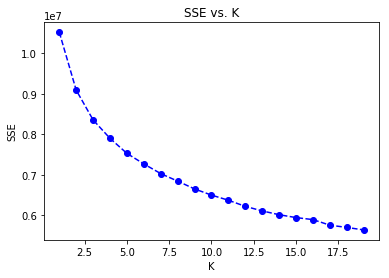

In [49]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [50]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

starttime = time.time()
kmeans = KMeans(n_clusters=20)
model_fit = kmeans.fit(azdias_pca)
predict_general = model_fit.predict(azdias_pca)

runtime = time.time() - starttime
print('Re-fit KMeans complete in {:.0f}m {:.0f}s'.format(runtime // 60, runtime % 60))

Re-fit KMeans complete in 5m 24s


### Discussion 3.1: Apply Clustering to General Population

Unfortunately, the processing time for KMean is significantly high for this amount of data. Therefore, the sample was set at 20% of the characteristics. This sample was enough to make the KMean model with 20 centers. However, no clearly recognizable elbow was displayed.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [87]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [88]:
# show the results before cleaning ....
num_rows, num_cols  = customers.shape
print('customers number of columns: {}'.format(num_cols))
print('customers number of rows: {}'.format(num_rows))
print(list(customers.columns.values))
customers.head()

customers number of columns: 85
customers number of rows: 191652
['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [89]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean, drop_col_c = clean_data(customers, missing_vals, feat_info)

In [90]:
# show the results after cleaning ....
num_rows, num_cols  = customers_clean.shape
print('customers number of columns: {}'.format(num_cols))
print('customers number of rows: {}'.format(num_rows))
print(list(customers_clean.columns.values))
customers_clean.head()

customers number of columns: 79
customers number of rows: 191652
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,0.0,5.0,5.0,1.0,5.0,1.0,2.0,2.0,2.0,...,1.0,5.0,5.0,1.0,2.0,1.0,2.0,3.0,5.0,3.0
1,4.0,0.0,NaN,5.0,1.0,5.0,1.0,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,1.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,...,3.0,3.0,2.0,3.0,5.0,3.0,2.0,3.0,3.0,4.0
3,4.0,0.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,6.0,...,1.0,3.0,4.0,1.0,3.0,1.0,1.0,3.0,4.0,4.0
4,3.0,0.0,6.0,3.0,1.0,4.0,4.0,5.0,2.0,2.0,...,2.0,3.0,3.0,3.0,5.0,1.0,1.0,3.0,2.0,1.0


In [91]:
# Check that columns have the right type
np.unique(customers_clean.dtypes.values)

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [92]:
# Compare columns from general data to customers data
list(set(azdias.columns) - set(customers_clean))

[]

In [93]:
# columns from costumers date to be remove ...
columns_removed = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                   'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
                   'SHOPPER_TYP','ZABEOTYP', 'W_KEIT_KIND_HH', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 
                   'CAMEO_DEU_2015',]
for col in columns_removed:
    customers_clean.drop(col, axis=1, inplace=True)
# sanity check the customers 
num_rows, num_cols  = customers_clean.shape
print('customers_clean data number of columns: {}'.format(num_cols))
print('customers_clean data number of rows: {}'.format(num_rows))    
# sanity check azdias ...
num_rows, num_cols  = azdias.shape
print('azdias data number of columns: {}'.format(num_cols))
print('azdias data number of rows: {}'.format(num_rows))

customers_clean data number of columns: 65
customers_clean data number of rows: 191652
azdias data number of columns: 65
azdias data number of rows: 891221


In [95]:
# for PCA ....
starttime = time.time()

customers_copy = customers_clean.copy()
c_features = pd.DataFrame(imputer.fit_transform(customers_copy))
customers_std = scaler.transform(c_features)
customers_pca = pca.transform(customers_std)
predict_customers = model_fit.predict(customers_pca)

runtime = time.time() - starttime
print('Customers PCA complete in {:.0f}m {:.0f}s'.format(runtime // 60, runtime % 60))

Customers PCA complete in 0m 6s


In [97]:
# check the results 
print(customers_pca.shape)

(191652, 35)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

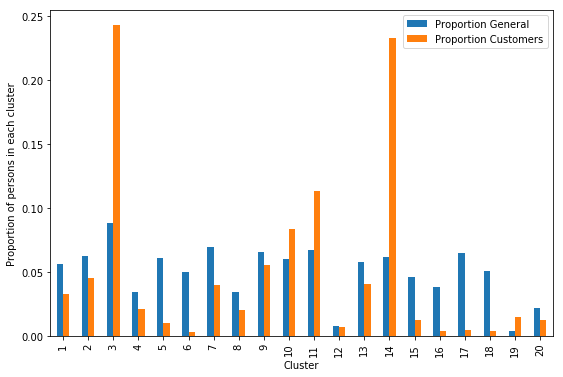

In [98]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_prop = []
customers_prop = []
x = [i+1 for i in range(20)]
for i in range(20):
    general_prop.append((predict_general == i).sum()/len(predict_general))
    customers_prop.append((predict_customers == i).sum()/len(predict_customers))

df_general = pd.DataFrame({'Cluster' : x, 'Proportion General' : general_prop, 'Proportion Customers':customers_prop})

df_general.plot(x='Cluster', y = ['Proportion General', 'Proportion Customers'], kind='bar', figsize=(9,6))
plt.ylabel('Proportion of persons in each cluster')
plt.show()

In [101]:
# Account for rows with many missing values
azdias_array = np.full((missing_vals.shape[0],), -1)
kmeans_all_azdias = np.concatenate([predict_general, azdias_array])

customers_array = np.full((missing_vals.shape[0],), -1)
kmeans_all_customers = np.concatenate([predict_customers, customers_array])


# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Proportions for general data
dict_data = {'proportion': pd.Series(kmeans_all_azdias).value_counts(normalize=True, sort=False), 
          'source': 'general'}

general_proportions = pd.DataFrame(dict_data)

# Proportions for customer data
dict_data = {'proportion': pd.Series(kmeans_all_customers).value_counts(normalize=True, sort=False), 
          'source': 'customer'}

customer_proportions = pd.DataFrame(dict_data)

# Concatenate proportions
total_proportions = pd.concat([general_proportions, customer_proportions])

In [102]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Check difference in cluster proportion for general vs customer populations
predict_customers_check = customer_proportions['proportion'] - general_proportions['proportion']
predict_customers_check.sort_values(ascending=False, inplace=True)
print('Overrepresented customers')
print(predict_customers_check[:3])
print('\n')
print('Underrepresented customers')
print(predict_customers_check[-3:])

Overrepresented customers
13    0.170625
2     0.154146
10    0.045381
Name: proportion, dtype: float64


Underrepresented customers
17   -0.046451
4    -0.050204
16   -0.060083
Name: proportion, dtype: float64


In [123]:
k=13
pca_cluster = azdias_pca[predict_general == k]
print('General cluster', k, 'accounts for', np.round(pca_cluster.shape[0]*100/features.shape[0],3), '% of population')

General cluster 13 accounts for 6.181 % of population


In [124]:
k=17
pca_cluster = azdias_pca[predict_general == k]
print('General cluster', k, 'accounts for', np.round(pca_cluster.shape[0]*100/features.shape[0],3), '% of population')

General cluster 17 accounts for 5.076 % of population


In [125]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
k=13
pca_cluster = customers_pca[predict_customers == k]
print('Customer cluster', k, 'accounts for', np.round(pca_cluster.shape[0]*100/features.shape[0],3), '% of population')

Customer cluster 13 accounts for 5.001 % of population


In [126]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
k=17
pca_cluster = customers_pca[predict_customers == k]
print('Customer cluster', k, 'accounts for', np.round(pca_cluster.shape[0]*100/features.shape[0],3), '% of population')

Customer cluster 17 accounts for 0.093 % of population


In [127]:
# cluster for customers
k=13
data = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(predict_customers==k)])).round()
df_1a = pd.DataFrame(data=data,
                   index=np.array(range(0, data.shape[0])),
                   columns=azdias.columns)
df_1a.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,-0.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,1.0,...,1.0,5.0,5.0,1.0,2.0,1.0,2.0,3.0,5.0,3.0
1,3.0,0.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,2.0,5.0,5.0,4.0,6.0,5.0,2.0,3.0,4.0,4.0
2,3.0,0.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,1.0,5.0,5.0,2.0,3.0,2.0,2.0,3.0,4.0,3.0
3,4.0,-0.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,1.0,...,1.0,3.0,3.0,3.0,4.0,3.0,2.0,3.0,5.0,5.0
4,3.0,0.0,5.0,2.0,4.0,1.0,3.0,1.0,1.0,3.0,...,1.0,5.0,5.0,3.0,6.0,4.0,2.0,3.0,5.0,5.0


In [128]:
# cluster for customers
k=17
data = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(predict_customers==k)])).round()
df_1b = pd.DataFrame(data=data,
                   index=np.array(range(0, data.shape[0])),
                   columns=azdias.columns)
df_1b.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,1.0,2.0,2.0,4.0,1.0,1.0,5.0,-0.0,2.0,...,5.0,5.0,3.0,4.0,9.0,3.0,1.0,3.0,1.0,1.0
1,2.0,1.0,1.0,4.0,2.0,5.0,3.0,5.0,-0.0,2.0,...,3.0,4.0,3.0,5.0,7.0,3.0,1.0,3.0,1.0,4.0
2,1.0,1.0,3.0,2.0,4.0,2.0,0.0,5.0,-0.0,3.0,...,5.0,3.0,2.0,4.0,7.0,3.0,1.0,3.0,1.0,1.0
3,1.0,1.0,1.0,4.0,3.0,4.0,3.0,4.0,-0.0,3.0,...,3.0,4.0,3.0,3.0,7.0,2.0,1.0,3.0,3.0,3.0
4,2.0,1.0,1.0,4.0,2.0,4.0,4.0,5.0,0.0,2.0,...,3.0,3.0,2.0,4.0,8.0,5.0,1.0,3.0,2.0,1.0


In [129]:
# cluster for azdias
k=13
data = scaler.inverse_transform(pca.inverse_transform(azdias_pca[np.where(predict_general==k)])).round()
df_2a = pd.DataFrame(data=data,
                   index=np.array(range(0, data.shape[0])),
                   columns=azdias.columns)
df_2a.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,3.0,0.0,4.0,3.0,3.0,3.0,4.0,2.0,1.0,3.0,...,2.0,3.0,3.0,2.0,6.0,2.0,2.0,2.0,5.0,3.0
1,3.0,-0.0,5.0,2.0,3.0,1.0,3.0,1.0,1.0,3.0,...,2.0,5.0,4.0,4.0,6.0,4.0,2.0,3.0,3.0,4.0
2,2.0,0.0,5.0,3.0,3.0,2.0,3.0,1.0,1.0,3.0,...,2.0,4.0,3.0,3.0,6.0,2.0,2.0,3.0,2.0,3.0
3,4.0,-0.0,5.0,2.0,4.0,2.0,2.0,1.0,1.0,2.0,...,1.0,4.0,4.0,3.0,5.0,3.0,2.0,2.0,3.0,3.0
4,3.0,-0.0,4.0,3.0,4.0,2.0,3.0,1.0,1.0,3.0,...,2.0,4.0,4.0,2.0,6.0,2.0,2.0,2.0,3.0,2.0


In [130]:
# cluster  for azdias
k=17
data = scaler.inverse_transform(pca.inverse_transform(azdias_pca[np.where(predict_general==k)])).round()
df_2b = pd.DataFrame(data=data,
                   index=np.array(range(0, data.shape[0])),
                   columns=azdias.columns)
df_2b.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1.0,1.0,5.0,2.0,3.0,4.0,4.0,0.0,1.0,...,5.0,4.0,2.0,4.0,10.0,5.0,1.0,2.0,1.0,1.0
1,2.0,1.0,2.0,2.0,4.0,2.0,3.0,4.0,0.0,2.0,...,4.0,4.0,3.0,4.0,9.0,4.0,1.0,3.0,3.0,1.0
2,2.0,1.0,2.0,4.0,2.0,3.0,4.0,3.0,0.0,3.0,...,4.0,5.0,3.0,3.0,9.0,4.0,1.0,3.0,2.0,1.0
3,1.0,1.0,1.0,4.0,3.0,4.0,4.0,5.0,0.0,3.0,...,3.0,4.0,3.0,4.0,7.0,4.0,1.0,3.0,2.0,1.0
4,1.0,1.0,1.0,5.0,2.0,4.0,4.0,4.0,-0.0,3.0,...,4.0,5.0,3.0,4.0,8.0,4.0,1.0,3.0,2.0,5.0


In [137]:
# Plot the demographics data for over or under represented for customers
def plot_cluster_demographics(k, pca_features, kmeans_labels):
    pca_cluster = pca_features[kmeans_labels == k]

    print('cluster', k, 'accounts for', np.round(pca_cluster.shape[0]*100/features.shape[0],3), '% of population')

    standardized_features = pca.inverse_transform(pca_cluster)
    features_cluster1 = scaler.inverse_transform(standardized_features)

    features_cluster1 = pd.DataFrame(np.round(features_cluster1), columns = azdias.columns)

    fig, axs = plt.subplots(2,3, figsize=(18,8))
    sns.countplot(features_cluster1['HH_EINKOMMEN_SCORE'], ax = axs[0,0], color='#33A1C9')
    sns.countplot(features_cluster1['FINANZ_HAUSBAUER'], ax = axs[0,1], color='#33A1C9')
    sns.countplot(features_cluster1['OST_WEST_KZ'], ax = axs[0,2], color='#33A1C9')
    sns.countplot(features_cluster1['SEMIO_SOZ'], ax = axs[1,0], color='#33A1C9')
    sns.countplot(features_cluster1['SEMIO_MAT'], ax = axs[1,1], color='#33A1C9')
    sns.countplot(features_cluster1['LIFE_STAGE'], ax = axs[1,2], color='#33A1C9')
    plt.show();

cluster 13 accounts for 5.001 % of population


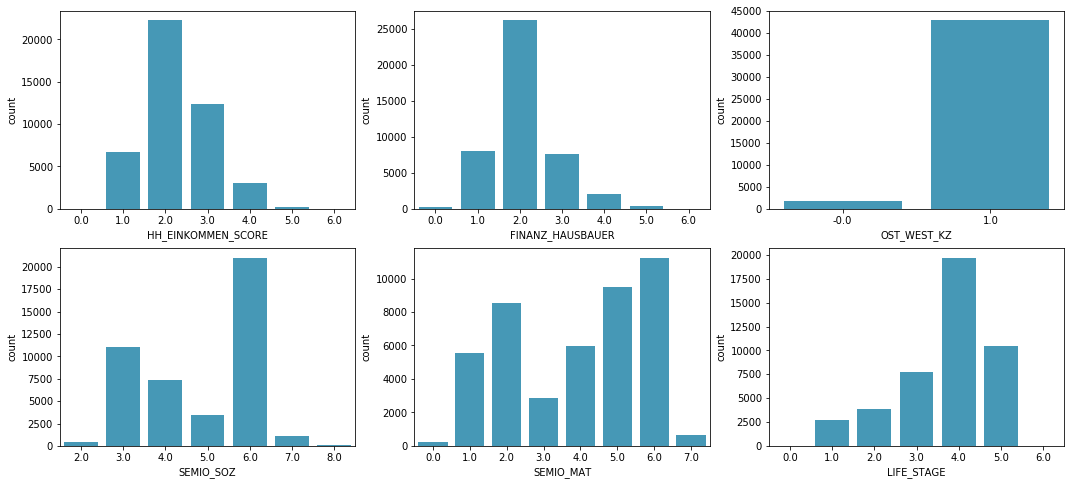

In [138]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
plot_cluster_demographics(k=13, pca_features=customers_pca, kmeans_labels=predict_customers)

cluster 17 accounts for 0.093 % of population


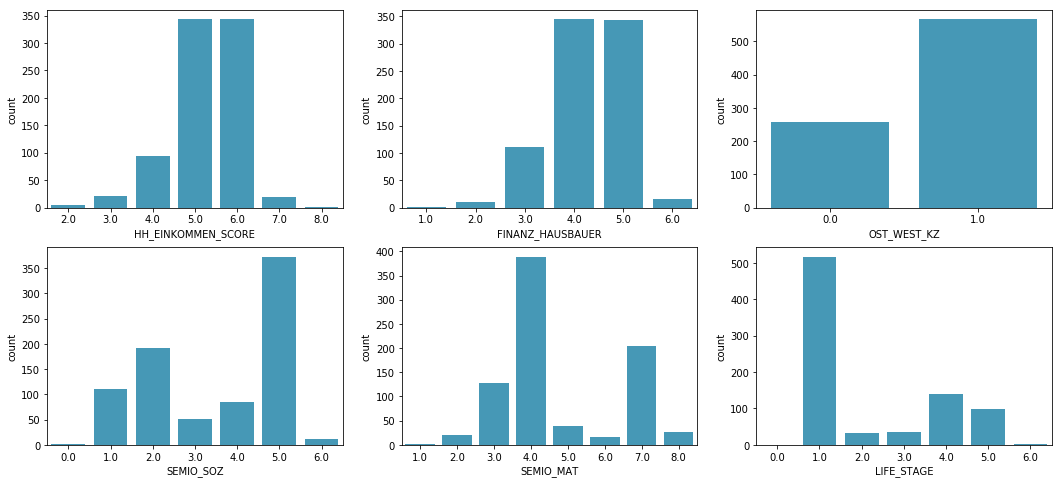

In [140]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
plot_cluster_demographics(k=17, pca_features=customers_pca, kmeans_labels=predict_customers)

### Discussion 3.3: Compare Customer Data to Demographics Data

With the analyzing popular and unpopular populations, the mail order company explored income, financial status, social status, and matierelle patterns. Two clusters, 13 and 17, were used for this:

Cluster 13 is over-represented in customer data compared to general population data. Some characteristics of the population that are relatively popular with mail-order companies are:
Financial typology home ownership (FINANZ_HAUSBAUER)
Estimated household net income (HH_EINKOMMEN_SCORE)
East or west of Germany (OST_WEST_KZ)

Cluster 17 is underrepresented in the customer data and indicates that the mail order company is considered a non-relevant vendor:
Personality typology socially-minded (SEMIO_SOZ)
Personality typology materialistic (SEMIO_MAT)
Part of life stage (LIFE_STAGE)

Summary: 
Population groups that are relatively popular with mail-order companies (in this case in cluster 13): Most of them are in the west of Germany and middle-income home builders.

Population groups that are relatively unpopular with mail-order companies (evaluated with cluster 17): are low-earners without a home with a low social status

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [141]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Identify_Customer_Segments.ipynb to html',
 '[NbConvertApp] Writing 843361 bytes to Identify_Customer_Segments.html']